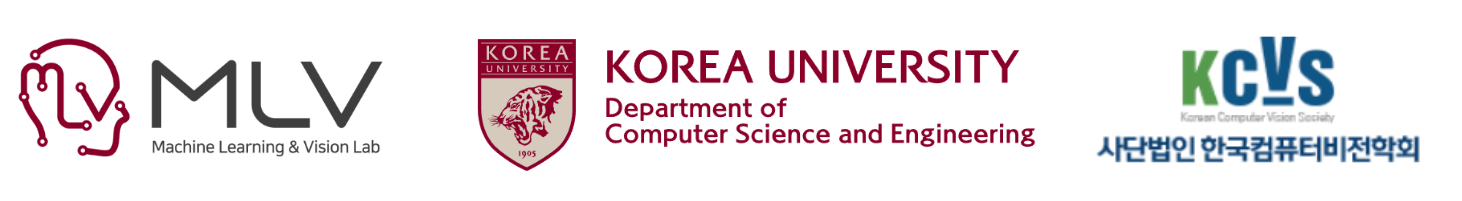

# **TokenMixup (NeurIPS 2022)**

Hyeong Kyu Choi<sup>*</sup>, Joonmyung Choi<sup>*</sup>, Hyunwoo J. Kim

[[paper](https://arxiv.org/abs/2210.07562)] [[github](https://github.com/mlvlab/TokenMixup)]

This Tutorial : https://github.com/mlvlab/KCCV2023_TokenMixup_Tutorial

![htm_gif](https://raw.githubusercontent.com/mlvlab/TokenMixup/main/assets/HTM.gif)


#### 1. Sample Difficulty Assessment (ScoreNet)

\begin{equation}
    \mathcal{F}(X^{(i)}, Y^{(i)}) = \textrm{CrossEntropy}(\textrm{ScoreNet}(X^{(i)}), Y^{(i)})
\end{equation}

#### 2. Attention-guided Saliency Detection

\begin{equation}
    A = \Phi^{(i)} \cdot \Phi^{(i+1)} \cdot \cdot \cdot \Phi^{(i+\ell)},
\end{equation}
\begin{equation}
    S_t = \displaystyle \frac{1}{n} \sum_{i=1}^n A_{i, t},
\end{equation}

#### 3. Optimal Assignment

\begin{equation}
    P_{i,j} \overset{\triangle}{=} S^{(j)} - S^{(i)},
\end{equation}
\begin{equation}
    C_{i,j} = \displaystyle \sum_{t=1}^n \textrm{max}(P_{i,j}^{(t)} - \rho,\: 0)
\end{equation}
\begin{equation}
    \sigma^* = \displaystyle \underset{\sigma}{\arg\max} \sum_{i=1}^n C_{i,\sigma(i)}.
\end{equation}

#### 4. Token-level Mixup
\begin{equation}
    M_t = 
    \begin{cases}
    \hspace{2mm}0  & ,\:\: S_t^{(j)} - \tilde{S}_t^{(i)} > \rho \\
    \hspace{2mm}1  & ,\:\: \textrm{otherwise}
    \end{cases}
\end{equation}
\begin{equation}
    \tilde{X}^{(i)}_{\textrm{mix}} = M \odot \tilde{X}^{(i)} + (1-M) \odot X^{(j)},
\end{equation}



-------------

<br>

## **실습 내용**

#### [1] TokenMixup 코드 리뷰
- 사전작업
- TokenMixup 모듈 코드 읽어보기
- 모델 로드 및 Input Mixup 알아보기

#### [2] ScoreNet 알아보기
- ScoreNet의 예측이 유의미한가?
- ScoreNet이 "어려움"의 척도(Proxy)가 될 수 있을까?

#### [3] Saliency Map 알아보기
- Attention 기반 방법이 정말 Salient한 영역을 잘 탐지하는가?
- TokenMixup을 통해 Saliency가 어떻게 향상되는가?

<br>

-------------

# **[1] TokenMixup 코드 리뷰**

### 사전 작업

In [ ]:
!git clone https://github.com/mlvlab/TokenMixup.git

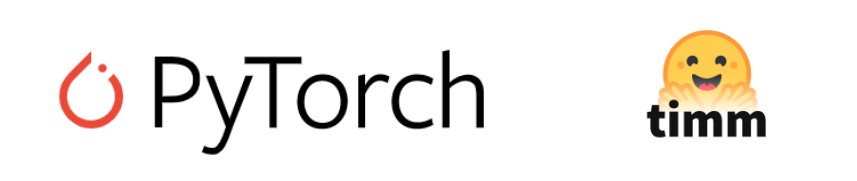

In [ ]:
# 필요한 패키지 설치
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install timm==0.6.7  # 유용한 Computer Vision Model 용 라이브러리 : https://github.com/rwightman/pytorch-image-models

In [ ]:
# 학습된 모델 파라미터 다운로드
%cd TokenMixup/experiments/
import gdown
gdown.download_folder('https://drive.google.com/drive/u/0/folders/1_iSo8cA088yg_y0naQQX3Vc6Q7jCGsQk')

### TokenMixup 모듈 코드 읽어보기


아래 코드는 설명을 위해 매우 간추린 버전으로, Compact Convolutional Transformer 모델과 같이 CLS 토큰이 없는 모델을 가정한 경우의 코드입니다. 

FULL CODE : [ [LINK](https://github.com/mlvlab/TokenMixup/blob/main/tokenmixup/horizontal.py) ]
```
class HorizontalTokenMixupLayer(nn.Module):
    def __init__(self, layer, tau, rho, scorenet_lambda,
                       ... ):
        super().__init__()

        # configs
        self.tau = tau
        self.rho = rho
        self.scorenet_lambda = scorenet_lambda
        self.aspect_ratio = aspect_ratio

        ...

        # encoder block
        self.layer = layer
        
        # scorenet
        self.scorenet_attn = nn.Linear(d_model, 1)
        self.scorenet_fc = nn.Linear(d_model, num_classes)


    def forward(self, x, y=None, *args, **kwargs):
        
        if not self.training :
            return self.layer(x, y, *args, **kwargs)


        # 1. Sample Difficulty Assessment
        self.difficulty_score = torch.zeros(BATCHSIZE, dtype=float)
        
        a = F.softmax(self.scorenet_attn(x), dim=1).transpose(-1, -2)
        scorenet_x = torch.matmul(a, x).squeeze(-2)
        scorenet_pred = self.scorenet_fc(scorenet_x)
        scorenet_loss = torch.sum(-y * F.log_softmax(scorenet_pred, dim=-1), dim=-1)

        self.difficulty_score = scorenet_loss.data
        apply_tokenmixup = self.difficulty_score <= self.tau


        # 2. Attention-guided Saliency Detection
        attn = self.layer.get_attention_map(x.data, y, *args, **kwargs).data
        _, attn_heads, attn_qdim, attn_kdim = attn.shape

        saliency = attn.mean(dim=[1, 2])
        x_to_mix, x_no_mix = x[apply_tokenmixup], x[~apply_tokenmixup]
        y_to_mix, y_no_mix = y[apply_tokenmixup], y[~apply_tokenmixup]
        saliency_to_mix = saliency[apply_tokenmixup] 


        # 3. Optimal Assignment
        raw_saliency_diff = saliency.repeat(mix_sample_num,1,1) - saliency_to_mix.reshape(mix_sample_num,1,N).repeat(1,B,1)
        saliency_diff = torch.clamp(raw_saliency_diff - self.rho, 0.0)
        saliency_diff_agg = saliency_diff.sum(dim=2)
        saliency_index = torch.tensor(linear_sum_assignment(-saliency_diff_agg)[1])
        saliency_pair_to_mix = saliency[saliency_index]

        
        # 4. Token-level Mixup
        ### actual mixup for x
        M  = torch.gather(saliency_diff, 1, saliency_index.unsqueeze(dim=-1).repeat(1, 1, N)).squeeze() > 0
        x_mixed = (~M).unsqueeze(-1).repeat(1, 1, D) * x_to_mix + M.unsqueeze(-1).repeat(1, 1, D) * x[saliency_index]
        x_mixed = torch.cat([x_mixed, x_no_mix], dim=0)

        ### actual mixup for y
        i = (saliency_to_mix * (~M)).sum(1)
        j = (saliency_pair_to_mix * M).sum(1)
        ratio_to_mix = (i / (i + j)).unsqueeze(-1)
        ratio_pair_to_mix = (j / (i + j)).unsqueeze(-1)
        y_mixed = ratio_to_mix * y_to_mix + ratio_pair_to_mix * y[saliency_index]
        y_mixed = torch.cat([y_mixed, y_no_mix], dim=0)

        return self.layer(x_mixed, y_mixed, *args, **kwargs)

```



### 모델 로드 및 Input Mixup 알아보기

In [ ]:
import torch
import torchvision
import numpy as np
from timm.models import create_model
from timm.data import create_dataset, create_loader, Mixup
from timm.loss import SoftTargetCrossEntropy

In [ ]:
# Setup Model
from cct.src.cct import cct_7_3x1_32

model = cct_7_3x1_32(
        horizontal_mixup = True,
        horizontal_layer = 2,  # 세번째 Layer에서 (Horizontal) TokenMixup 적용
        rho = 0.003,           # Saliency Difference Threshold
        tau = 100,             # Sample Difficulty Threshold : 모두 섞기 위해 임의로 100 지정
        scorenet_stopgrad = False,
        scorenet_train = True,
        vertical_mixup = False,
        vertical_layer = -1,
        kappa = 0,
        vertical_stopgrad = True,
        img_size = 32,
        seq_pool = True,
        pretrained = False,
        num_classes = 10,
        drop_rate = 0.0,
        drop_connect_rate = 0.0,
        drop_block_rate = 0.0,
        global_pool = 0,
        bn_tf = False,
        bn_momentum = 0.0,
        bn_eps = 0.0,
        scriptable = False,
)

checkpoint = torch.load("TokenMixup-KCCV/cct_cifar10_htm.pth.tar", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['state_dict'], strict=True)

loss_fn = SoftTargetCrossEntropy()

In [ ]:
BATCH_SIZE = 4

# Setup Dataset and Data Loader
dataset_train = create_dataset(
    "torch/cifar10", download=True, batch_size=BATCH_SIZE,
    root="./", split="train", is_training=True
)
loader_train = create_loader(dataset_train, input_size=(3,32,32), 
                             batch_size=BATCH_SIZE, use_prefetcher=False,
                             mean=[0.4914, 0.4822, 0.4465],
                             std=[0.247, 0.2435, 0.2616])

dataset_test = create_dataset(
    "torch/cifar10", download=True, batch_size=BATCH_SIZE,
    root="./", split="test", is_training=False
)
loader_test = create_loader(dataset_test, input_size=(3,32,32), 
                             batch_size=BATCH_SIZE, use_prefetcher=False,
                             mean=[0.4914, 0.4822, 0.4465],
                             std=[0.247, 0.2435, 0.2616])

# Setup Input Mixup
mixup_fn = Mixup(mixup_alpha=10, cutmix_alpha=0.0, cutmix_minmax=None,
                 switch_prob=0.0, mode="batch", label_smoothing=0.1, 
                 num_classes=10, prob=1.0)
no_mixup = Mixup(mixup_alpha=10, cutmix_alpha=0.0, cutmix_minmax=None,
                 switch_prob=0.0, mode="batch", label_smoothing=0.1, 
                 num_classes=10, prob=0.0)

In [ ]:
from matplotlib import pyplot as plt

LABELS = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

for bidx, (input, target) in enumerate(loader_train):
  if bidx in [1] :
    # Input Mixup X
    raw_input, raw_target = no_mixup(input, target)
    out = torchvision.utils.make_grid(raw_input)
    out = torch.clamp(out * torch.tensor([[[0.247]],[[0.2435]],[[0.2616]]]) + torch.tensor([[[0.4914]],[[0.4822]],[[0.4465]]]), 0, 1)

    plt.figure(figsize=(10,10))
    plt.title([LABELS[x.argmax(0).item()] for x in raw_target])
    plt.imshow(out.permute(1,2,0))
    plt.pause(0.001)

    model.eval()    
    raw_pred = model(raw_input, raw_target)
    raw_losses = torch.sum(-raw_target * torch.nn.functional.log_softmax(raw_pred, dim=-1), dim=-1)
    print("Sample Losses = {:.4f}, {:.4f}, {:.4f}, {:.4f}\n\n".format(*raw_losses))

    # Input Mixup O
    mix_input, mix_target = mixup_fn(input, target)
    out = torchvision.utils.make_grid(mix_input)
    out = torch.clamp(out * torch.tensor([[[0.247]],[[0.2435]],[[0.2616]]]) + torch.tensor([[[0.4914]],[[0.4822]],[[0.4465]]]), 0, 1)

    plt.figure(figsize=(10,10))
    plt.title([LABELS[x.topk(2).indices[0]]+'+'+LABELS[x.topk(2).indices[1]] for x in mix_target])
    plt.imshow(out.permute(1,2,0))
    plt.pause(0.001)

    mix_pred = model(mix_input, mix_target)
    mix_losses = torch.sum(-mix_target * torch.nn.functional.log_softmax(mix_pred, dim=-1), dim=-1)
    print("Sample Losses = {:.4f}, {:.4f}, {:.4f}, {:.4f}\n\n".format(*mix_losses))

    break

# **[2] ScoreNet 알아보기**

### ScoreNet의 예측이 유의미한가?



In [ ]:
from matplotlib import pyplot as plt

LABELS = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

for bidx, (input, target) in enumerate(loader_test):
  if bidx < 3 :
    raw_input, raw_target = no_mixup(input, target)
    out = torchvision.utils.make_grid(raw_input)
    out = torch.clamp(out * torch.tensor([[[0.247]],[[0.2435]],[[0.2616]]]) + torch.tensor([[[0.4914]],[[0.4822]],[[0.4465]]]), 0, 1)
    plt.figure(figsize=(10,10))
    plt.title([LABELS[x.argmax(0).item()] for x in raw_target])
    plt.imshow(out.permute(1,2,0))
    plt.pause(0.001)
    
    model.eval()
    raw_pred = model(raw_input, raw_target)
    model.train()
    _, _, raw_scorenet_output, _, _, _ = model(raw_input, raw_target)
    print("Model    Predictions = {}, {}, {}, {}".format(*[LABELS[x.argmax(0).item()] for x in raw_pred]))
    print("ScoreNet Predictions = {}, {}, {}, {}\n\n".format(*[LABELS[x.argmax(0).item()] for x in raw_scorenet_output]))

  else :
    break


### ScoreNet이 "어려움"의 척도가 될 수 있을까?

In [ ]:
import tqdm

LABELS = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

MODEL_LOSSES = []
SCORENET_LOSSES = []

for bidx, (input, target) in tqdm.tqdm(enumerate(loader_test)):

  mix_input, mix_target = mixup_fn(input, target)
  model.eval()
  mix_pred = model(mix_input, mix_target)
  model.train()
  mix_scorenet_output = model(mix_input, mix_target)[2]

  mix_losses = torch.sum(-mix_target * torch.nn.functional.log_softmax(mix_pred, dim=-1), dim=-1)
  mix_sn_losses = torch.sum(-mix_target * torch.nn.functional.log_softmax(mix_scorenet_output, dim=-1), dim=-1)
  
  MODEL_LOSSES += list(np.array(mix_losses.detach()))
  SCORENET_LOSSES += list(np.array(mix_sn_losses.detach()))

  if bidx == 19 : break

In [ ]:
# Scatter Plot
fig, ax = plt.subplots(figsize = (5, 5))
ax.scatter(SCORENET_LOSSES, MODEL_LOSSES, s=60, alpha=0.7, edgecolors="k")
plt.xlim(min(SCORENET_LOSSES)-0.3,max(SCORENET_LOSSES)+0.3)
plt.ylim(min(MODEL_LOSSES)-0.3,max(MODEL_LOSSES)+0.3)
plt.xlabel('Scorenet Loss')
plt.ylabel('Model Loss')
plt.title("PEARSON CORR. : {:.2f}".format(np.corrcoef(SCORENET_LOSSES, MODEL_LOSSES)[0,1]))

# Line Plot
b, a = np.polyfit(SCORENET_LOSSES, MODEL_LOSSES, deg=1)
xseq = np.linspace(min(SCORENET_LOSSES)-0.2, max(SCORENET_LOSSES)+0.2, num=100)
ax.plot(xseq, a + b * xseq, color="r", lw=2.5);
plt.show()
plt.close()

<br>

# **[3] Saliency Map 알아보기**

### Attention 기반 방법이 정말 Salient한 영역을 잘 탐지하는가?

In [ ]:
# TokenMixup 을 수행하지 않는 모델을 따로 정의

from cct.src.cct import cct_7_3x1_32

raw_model = cct_7_3x1_32(
        horizontal_mixup = False,
        horizontal_layer = -1,
        rho = 0.00,          
        tau = 0.0,            
        scorenet_stopgrad = False,
        scorenet_train = True,
        vertical_mixup = False,
        vertical_layer = -1,
        kappa = 0,
        vertical_stopgrad = True,
        img_size = 32,
        seq_pool = True,
        pretrained = False,
        num_classes = 10,
        drop_rate = 0.0,
        drop_connect_rate = 0.0,
        drop_block_rate = 0.0,
        global_pool = 0,
        bn_tf = False,
        bn_momentum = 0.0,
        bn_eps = 0.0,
        scriptable = False,
)

checkpoint = torch.load("TokenMixup-KCCV/cct_cifar10_htm.pth.tar", map_location=torch.device('cpu'))
raw_model.load_state_dict(checkpoint['state_dict'], strict=False)

In [ ]:
from matplotlib import pyplot as plt

LABELS = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
TOPK = 50

for bidx, (input, target) in enumerate(loader_train):
  if bidx in [10,14] :
    raw_input, raw_target = no_mixup(input, target)
    out = torchvision.utils.make_grid(raw_input)
    out = torch.clamp(out * torch.tensor([[[0.247]],[[0.2435]],[[0.2616]]]) + torch.tensor([[[0.4914]],[[0.4822]],[[0.4465]]]), 0, 1)

    plt.figure(figsize=(10,10))
    plt.title([LABELS[x.argmax(0).item()] for x in raw_target])
    plt.imshow(out.permute(1,2,0))
    plt.pause(0.001)

    # Get Saliency with Attention
    model.train()    
    raw_pred, raw_lbl, raw_scorenet_output, raw_attns, raw_K1s, raw_K2s = raw_model(raw_input, raw_target)
    
    for i, at in enumerate(raw_attns[2:]):
      if i == 0 :
        sal = at.mean(1)
      else :
        sal = torch.matmul(sal.transpose(2,1), at.mean(1))
    saliency = sal.mean(1)

    # Select Top Salient Tokens
    topk = torch.topk(saliency, 256 - TOPK, largest=False)
    top_sal = saliency.scatter_(1, topk.indices, 0).reshape(BATCH_SIZE, 16,16)
    saliency = torch.nn.functional.interpolate(top_sal.unsqueeze(1), size=(32,32))
    sal_map = torch.nn.functional.pad(saliency,(0,0,0,0,1,1))
    
    out = torchvision.utils.make_grid(raw_input + 255 * sal_map)
    out = torch.clamp(out * torch.tensor([[[0.247]],[[0.2435]],[[0.2616]]]) + torch.tensor([[[0.4914]],[[0.4822]],[[0.4465]]]), 0, 1)
    
    plt.figure(figsize=(10,10))
    plt.title([LABELS[x.argmax(0).item()] for x in raw_target])
    plt.imshow(out.permute(1,2,0))
    plt.pause(0.001)

  elif bidx > 14 :
    break


### TokenMixup을 통해 Saliency가 어떻게 향상되는가?

In [ ]:
from matplotlib import pyplot as plt

LABELS = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

RHOS = [1.0, 0.01, 0.003, 0.000]

SAL_INC = [[],[],[],[]]

for bidx, (input, target) in tqdm.tqdm(enumerate(loader_train)):
  raw_input, raw_target = no_mixup(input, target)

  # Saliency without TokenMixup
  raw_model.train()    
  raw_pred, raw_lbl, raw_scorenet_output, raw_attns, raw_K1s, raw_K2s = raw_model(raw_input, raw_target)
  for i, at in enumerate(raw_attns[2:]):
    if i == 0 :
      raw_sal = at.mean(1)
    else :
      raw_sal = torch.matmul(raw_sal.transpose(2,1), at.mean(1))
  raw_sal = raw_sal.mean(1)

  raw_saliency_diff = raw_sal.repeat(4,1,1) - raw_sal.reshape(4,1,256).repeat(1,4,1)
  for i, rho in enumerate(RHOS) :
    saliency_diff = torch.clamp(raw_saliency_diff - rho, 0.0)
    SAL_INC[i] += list(np.array(saliency_diff.mean(1).sum(1)))

  if bidx == 14 :
    break

MEAN_SAL_INC = [sum(L)/len(L) + 1 for L in SAL_INC]  

fig = plt.figure(figsize=(10,5))
pos = np.arange(len(SAL_INC)) + 1
ax = fig.add_axes([0,0,1,1])
ax.bar(pos - 0.15, [1] * len(RHOS), color='lightblue', width = 0.3)
ax.bar(pos + 0.15, MEAN_SAL_INC, color='pink', width = 0.3)
plt.xticks(pos, RHOS)
plt.xlabel("Saliency Difference Threshold (Rho)")
plt.ylabel("Saliency Level")
plt.ylim(0.5)
plt.legend(["original saliency", "increased saliency"])
plt.show()
plt.close()